# Deep learning Spring 2025

- **Name:** `Ali Zahedzadeh`
- **Student ID:** `4021305965003`



---



- **Name:** `Peyman Naseri`
- **Student ID:** `4011305965014`



<hr>

## 2-2. Image Preprocessing and Data Augmentation

### Dataset Splitting
The original dataset includes images from two classes: cats and dogs. According to the problem statement, the dataset is split into:
- **70% training set**: used to train the model.
- **30% validation set**: used for model selection and hyperparameter tuning.
- The **test set** is already provided separately and will be used later for final evaluation.

We prepared **two versions** of the training/validation datasets:
1. **Augmented dataset**: with transformations applied only to the training portion.
2. **Raw dataset**: without any augmentation.

### Applied Augmentation Techniques (on Augmented version)
Based on Section 4.2 of the paper, the following data augmentation techniques were applied on the training set:
1. **Random Horizontal Flip**  
2. **Random Rotation (±30 degrees)**  
3. **Random Zoom (scale range 0.75 to 1.25)**  

These augmentations help increase the diversity of the dataset and reduce overfitting.

### Preprocessing for CNN Models
To ensure compatibility with VGG16 and ResNet50, all images in both datasets are:
- Resized or cropped to a fixed size of **224x224**
- Converted to tensors
- Normalized using ImageNet statistics

### Number of Samples
- Total training+validation images: **702**
- After 70/30 split:
  - **Training set**: 491 images
  - **Validation set**: 211 images
- Data augmentation increases the *effective* number of training samples during each epoch through transformations, though the base number remains 350.


### Test Set
A separate test set of **100 images** is provided for final evaluation.

### Summary
| Dataset Version     | Augmentation Applied | Train Size | Val Size |
|---------------------|----------------------|------------|----------|
| **Augmented**       | Yes (Train only)     | 491        | 211      |
| **Raw**             | No                   | 491        | 211      |


### Note:
Although the paper mentions 500 training images in total, the actual dataset contains 702 images, which were split accordingly.


In [ ]:
# Install gdown if needed
!pip install -q gdown

# Import libraries
import gdown
import zipfile
import os

# Extract the Google Drive file ID from the link
file_id = "1Uy2MBoGhzOMoKpULfkbeFHa9dT4uuSTJ"

# Define the target directory (change it to your desired path)
output_dir = "/home/p_naseri/Deep_Learning/HW2"
os.makedirs(output_dir, exist_ok=True)

# Define the path to save the downloaded zip file
zip_path = os.path.join(output_dir, "dataset.zip")

# Create the direct download link and download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Delete the zip file after extraction (optional)
os.remove(zip_path)

print(f"Dataset extracted to: {output_dir}")


Downloading...
From: https://drive.google.com/uc?id=1Uy2MBoGhzOMoKpULfkbeFHa9dT4uuSTJ
To: /home/p_naseri/Deep_Learning/HW2/dataset.zip
100%|██████████| 18.4M/18.4M [00:00<00:00, 123MB/s] 


Dataset extracted to: /home/p_naseri/Deep_Learning/HW2


In [ ]:
# Dataset paths
prepath = "/home/p_naseri/Deep_Learning/HW2"
dataset_path = prepath + "/HW2_Dataset/Train"
test_path = prepath + "/HW2_Dataset/Test"
IMAGE_SIZE = 224


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

In [ ]:
# Define transforms
augmented_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

raw_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# Load dataset without any transform initially
base_dataset = datasets.ImageFolder(root=dataset_path, transform=None)
# Test set (no augmentation)
test_dataset = datasets.ImageFolder(root=test_path, transform=raw_transforms)

# Split the base dataset (same split for both versions)
train_size = int(0.7 * len(base_dataset))
val_size = len(base_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(base_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Manually assign transforms to each split version

# For raw version (no augmentation)
train_raw = torch.utils.data.Subset(base_dataset, train_indices)
val_raw = torch.utils.data.Subset(base_dataset, val_indices)
train_raw.dataset.transform = raw_transforms
val_raw.dataset.transform = raw_transforms

# For augmented version (augmentation only on train)
train_aug = torch.utils.data.Subset(base_dataset, train_indices)
val_aug = torch.utils.data.Subset(base_dataset, val_indices)
train_aug.dataset.transform = augmented_transforms
val_aug.dataset.transform = raw_transforms

# DataLoaders
train_loader_raw = DataLoader(train_raw, batch_size=10, shuffle=True)
val_loader_raw = DataLoader(val_raw, batch_size=10, shuffle=False)

train_loader_aug = DataLoader(train_aug, batch_size=10, shuffle=True)
val_loader_aug = DataLoader(val_aug, batch_size=10, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
# Print stats
print(f"Total images (Train + Val): {len(base_dataset)}")
print(f"Train size: {len(train_raw)}")
print(f"Validation size: {len(val_raw)}")
print(f"Test size: {len(test_dataset)}")

Total images (Train + Val): 702
Train size: 491
Validation size: 211
Test size: 100


## 2-3. Implementation: Fine-Tuning Setup for VGG16 and ResNet50

In this step, we prepare fine-tuned versions of two popular CNN architectures: **VGG16** and **ResNet50**, based on the fine-tuning strategy described in Section 4.1 of the paper.

> **Note:** No training is performed in this step. The goal is to prepare the models and configure their trainable layers so that they are ready for training in the next phase.

---

### Fine-Tuning Details (Model-specific)

#### 🔵 VGG16:
According to the paper, the fine-tuned VGG16 model has 32.7 million trainable parameters, consisting of:
- The final classifier (fully connected layers)
- The last convolutional block (`Conv5`)

**Steps followed:**
1. Load the pretrained VGG16 model (on ImageNet).
2. Replace the classifier with a 3-layer fully connected module for binary classification.
3. Freeze all convolutional layers **except** the last convolutional block (`Conv5`).
4. Keep the classifier layers trainable.

#### 🔴 ResNet50:
According to Table 1 of the paper, the fine-tuned ResNet50 model has 1.06 million trainable parameters, including:
- The last convolutional block (`layer4`)
- The final fully connected layer
- All Batch Normalization layers

**Steps followed:**
1. Load the pretrained ResNet50 model.
2. Replace the final FC layer with a new binary classification layer.
3. Freeze all layers **except**:
   - `layer4` (last residual block)
   - BatchNorm layers
   - The new FC layer

---


### Model–Dataset Combinations
We prepare the following **4 model–dataset pairs**, each ready to be trained on its corresponding data:

| Model     | Dataset Type   | Description                        |
|-----------|----------------|------------------------------------|
| VGG16     | Augmented       | Augmented training set             |
| VGG16     | Raw             | Non-augmented training set         |
| ResNet50  | Augmented       | Augmented training set             |
| ResNet50  | Raw             | Non-augmented training set         |


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== VGG16 (Fine-Tune Conv5 + FC layers only) ==========
def prepare_vgg16():
    model = models.vgg16(pretrained=True)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # # Replace the classifier
    # model.classifier = nn.Sequential(
    #     nn.Linear(25088, 4096),
    #     nn.ReLU(),
    #     nn.Dropout(),
    #     nn.Linear(4096, 4096),
    #     nn.ReLU(),
    #     nn.Dropout(),
    #     nn.Linear(4096, 2)
    # )

    # Unfreeze conv5 block (layers 24 to 29 in features)
    for name, param in model.features.named_parameters():
        if any(str(i) in name for i in range(24, 30)):
            param.requires_grad = True


    # Modify only the last layer of classifier
    input_features = model.classifier[6].in_features  # usually 4096
    model.classifier[6] = nn.Linear(input_features, 2)


    # Classifier is also trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model.to(device)

# ========== ResNet50 (Fine-Tune layer4 + fc + batchnorm only) ==========
def prepare_resnet50():
    model = models.resnet50(pretrained=True)

    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final classifier
    model.fc = nn.Linear(model.fc.in_features, 2)

    # Unfreeze layer4 (last conv block)
    for name, param in model.named_parameters():
        if "layer4" in name:
            param.requires_grad = True

    # Unfreeze batch norm layers
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            for param in module.parameters():
                param.requires_grad = True

    # Unfreeze the new fc layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)

# Four model-dataset combos
vgg_aug = prepare_vgg16()
vgg_raw = prepare_vgg16()
resnet_aug = prepare_resnet50()
resnet_raw = prepare_resnet50()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

In [ ]:
vgg_raw

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
resnet_raw

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 2.4. Evaluation and Analysis

This section evaluates the performance of the fine-tuned CNN models using both the augmented and raw versions of the dataset.

### Hyperparameters

The following hyperparameters, originally described in Table 2 of the paper, are used throughout this section for all training runs:

- **Initial Learning Rate:** 0.001 (in paper 0.1)
- **Learning Rate Decay:** 0.002  
- **Momentum:** 0.9  
- **Batch Size:** 10  
- **Epochs:** 50  

> ⚠️ Note: These hyperparameters were originally defined in Section 2-3, but they are now implemented and applied here in Section 2-4 where the actual training takes place.

---

### 2.4.1. Training

In this step, we train each of the prepared model–dataset pairs over 50 epochs.

Each model is trained twice:
- Once using the augmented dataset.
- Once using the raw (non-augmented) dataset.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_all_models(
    models_dict,  # a dict like {'VGG16': {'Raw': model1, 'Augmented': model2}, ...}
    loaders_dict,  # a dict like {'Raw': (train_loader_raw, val_loader_raw), 'Augmented': (...)}
    num_epochs=50,
    lr=0.001,
    decay=0.002,
    momentum=0.9
):
    """
    Trains all models for both dataset types (Raw & Augmented) and stores accuracy/loss.

    Args:
        models_dict: nested dict of models per network and dataset type
        loaders_dict: dict of (train_loader, val_loader) per dataset type
        num_epochs: number of epochs
        lr: initial learning rate
        decay: learning rate decay per epoch
        momentum: SGD momentum

    Returns:
        results: nested dictionary containing accuracy and loss logs
    """


    results = {}

    for model_name in models_dict:
        results[model_name] = {}

        for data_type in models_dict[model_name]:
            print(f"\n>>> Training {model_name} on {data_type} data")

            model = models_dict[model_name][data_type].to(device)
            train_loader, val_loader = loaders_dict[data_type]

            # Define loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=lr, momentum=momentum
            )
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1 - decay)

            # Logs
            train_acc, val_acc = [], []
            train_loss, val_loss = [], []

            for epoch in range(num_epochs):
                model.train()
                correct_train = total_train = 0
                running_loss_train = 0.0

                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss_train += loss.item() * labels.size(0)
                    _, preds = outputs.max(1)
                    correct_train += preds.eq(labels).sum().item()
                    total_train += labels.size(0)

                avg_train_loss = running_loss_train / total_train
                train_accuracy = correct_train / total_train
                train_loss.append(avg_train_loss)
                train_acc.append(train_accuracy)

                # Validation
                model.eval()
                correct_val = total_val = 0
                running_loss_val = 0.0

                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)

                        running_loss_val += loss.item() * labels.size(0)
                        _, preds = outputs.max(1)
                        correct_val += preds.eq(labels).sum().item()
                        total_val += labels.size(0)


                avg_val_loss = running_loss_val / total_val
                val_accuracy = correct_val / total_val
                val_loss.append(avg_val_loss)
                val_acc.append(val_accuracy)

                scheduler.step()

                # Logging each epoch
                print(f"[{model_name} | {data_type}] Epoch {epoch+1}/{num_epochs} - "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, "
                      f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Save logs
            results[model_name][data_type] = {
                'train_acc': train_acc,
                'val_acc': val_acc,
                'train_loss': train_loss,
                'val_loss': val_loss
            }

    return results


In [ ]:
# Models must be freshly initialized (no shared weights)
models_dict = {
    'VGG16': {
        'Raw': prepare_vgg16(),
        'Augmented': prepare_vgg16()
    },
    'ResNet50': {
        'Raw': prepare_resnet50(),
        'Augmented': prepare_resnet50()
    },
}

# Data loaders (assumes you've already created these in earlier steps)
loaders_dict = {
    'Raw': (train_loader_raw, val_loader_raw),
    'Augmented': (train_loader_aug, val_loader_aug)
}

# Start training all models and gather logs
results = train_all_models(models_dict, loaders_dict)



>>> Training VGG16 on Raw data
[VGG16 | Raw] Epoch 1/50 - Train Acc: 0.9267, Val Acc: 0.9810, Train Loss: 0.1681, Val Loss: 0.0478
[VGG16 | Raw] Epoch 2/50 - Train Acc: 1.0000, Val Acc: 0.9858, Train Loss: 0.0074, Val Loss: 0.0344
[VGG16 | Raw] Epoch 3/50 - Train Acc: 1.0000, Val Acc: 0.9905, Train Loss: 0.0037, Val Loss: 0.0352
[VGG16 | Raw] Epoch 4/50 - Train Acc: 1.0000, Val Acc: 0.9858, Train Loss: 0.0014, Val Loss: 0.0383
[VGG16 | Raw] Epoch 5/50 - Train Acc: 1.0000, Val Acc: 0.9858, Train Loss: 0.0010, Val Loss: 0.0413
[VGG16 | Raw] Epoch 6/50 - Train Acc: 1.0000, Val Acc: 0.9858, Train Loss: 0.0010, Val Loss: 0.0401
[VGG16 | Raw] Epoch 7/50 - Train Acc: 1.0000, Val Acc: 0.9763, Train Loss: 0.0014, Val Loss: 0.0488
[VGG16 | Raw] Epoch 8/50 - Train Acc: 1.0000, Val Acc: 0.9858, Train Loss: 0.0006, Val Loss: 0.0447
[VGG16 | Raw] Epoch 9/50 - Train Acc: 1.0000, Val Acc: 0.9810, Train Loss: 0.0005, Val Loss: 0.0466
[VGG16 | Raw] Epoch 10/50 - Train Acc: 1.0000, Val Acc: 0.9810, Trai

In [ ]:
import pickle

# Save the results to a file
with open("training_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("Training results saved to training_results.pkl")


Training results saved to training_results.pkl


In [ ]:
from google.colab import files
files.download("training_results.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.4.2. Accuracy Curves

This section presents the accuracy plots for both VGG16 and ResNet50, trained using:
- **Raw dataset** (without data augmentation)
- **Augmented dataset**

Each model was trained for 50 epochs using the hyperparameters defined in the previous section. The training and validation accuracy values were recorded at each epoch.

### Goal:
To compare how data augmentation affects the generalization ability of the CNN models.

The following figures show side-by-side comparisons of accuracy curves:
- Left: using raw (non-augmented) data
- Right: using augmented data


In [ ]:
# # Load the saved results
# with open("training_results.pkl", "rb") as f:
#     results = pickle.load(f)

# print("Training results loaded.")


NameError: name 'pickle' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison_accuracy(train_acc_raw, val_acc_raw, train_acc_aug, val_acc_aug, model_name):
    """
    Draws side-by-side accuracy plots for raw and augmented training.

    Args:
        train_acc_raw: list of training accuracy (raw data)
        val_acc_raw: list of validation accuracy (raw data)
        train_acc_aug: list of training accuracy (augmented data)
        val_acc_aug: list of validation accuracy (augmented data)
        model_name: name of the model for labeling
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot raw data accuracy
    axes[0].plot(train_acc_raw, label='Train Accuracy')
    axes[0].plot(val_acc_raw, label='Validation Accuracy')
    axes[0].set_title(f'{model_name} Accuracy (Raw Data)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    axes[0].legend()

    # Plot augmented data accuracy
    axes[1].plot(train_acc_aug, label='Train Accuracy')
    axes[1].plot(val_acc_aug, label='Validation Accuracy')
    axes[1].set_title(f'{model_name} Accuracy (Augmented Data)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)
    axes[1].legend()

    fig.suptitle(f'{model_name} Accuracy Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


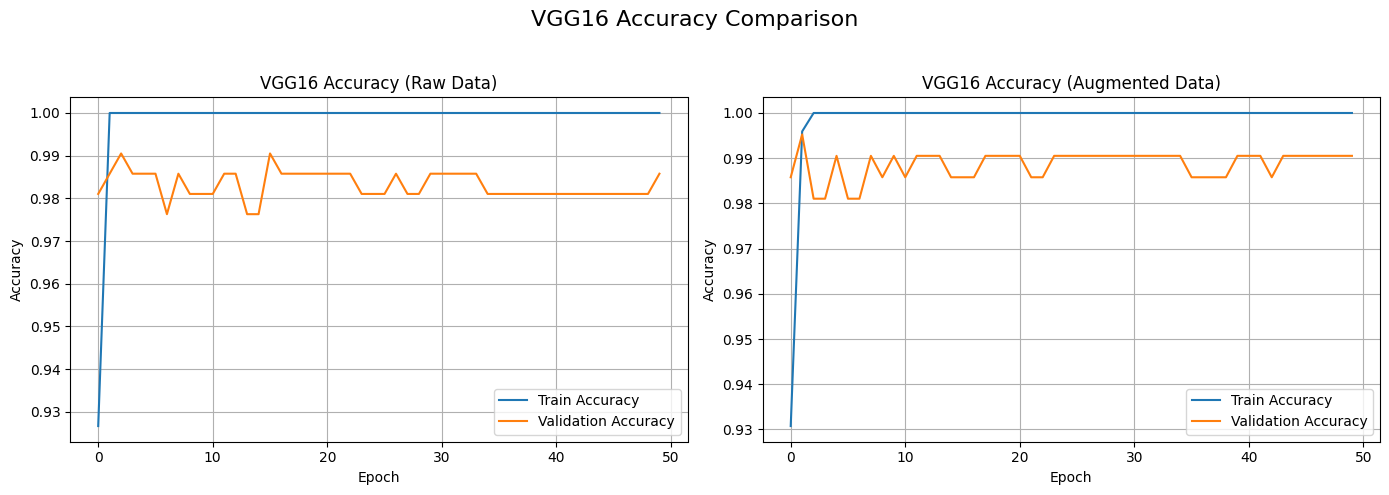

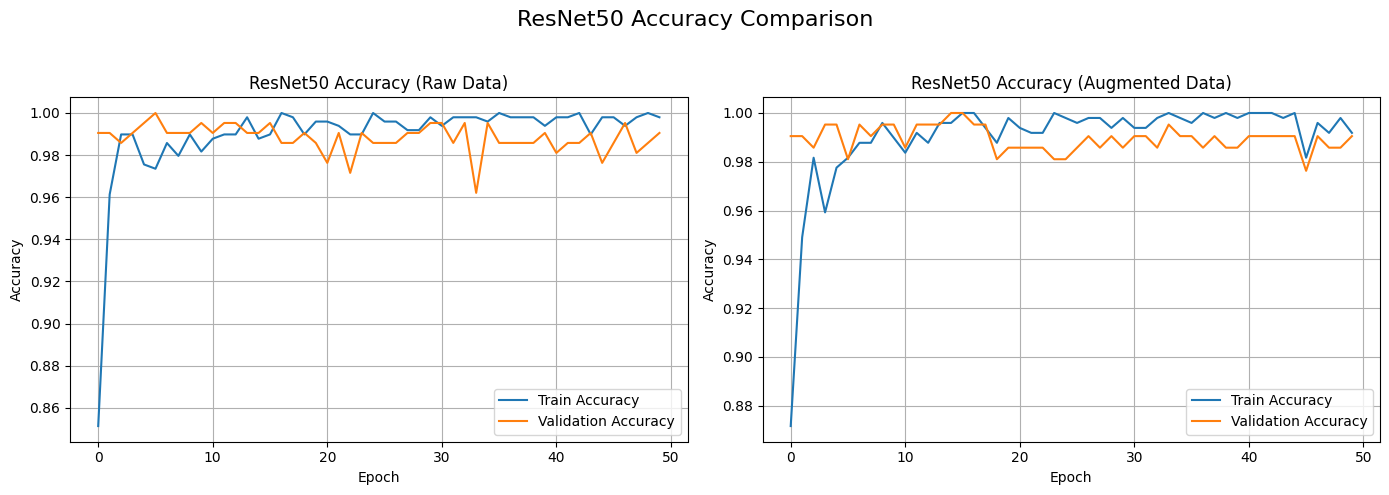

In [ ]:
plot_comparison_accuracy(
    train_acc_raw=results['VGG16']['Raw']['train_acc'],
    val_acc_raw=results['VGG16']['Raw']['val_acc'],
    train_acc_aug=results['VGG16']['Augmented']['train_acc'],
    val_acc_aug=results['VGG16']['Augmented']['val_acc'],
    model_name="VGG16"
)

plot_comparison_accuracy(
    train_acc_raw=results['ResNet50']['Raw']['train_acc'],
    val_acc_raw=results['ResNet50']['Raw']['val_acc'],
    train_acc_aug=results['ResNet50']['Augmented']['train_acc'],
    val_acc_aug=results['ResNet50']['Augmented']['val_acc'],
    model_name="ResNet50"
)



#### ✦ VGG16 Accuracy Curves

- **Left Plot (Raw Data):**  
  The VGG16 model reaches 100% training accuracy in the very early epochs. The validation accuracy fluctuates slightly between 98% and 99%, which may be attributed to the relatively small validation set size or mild overfitting.

- **Right Plot (Augmented Data):**  
  The model also converges quickly to perfect training accuracy. The validation curve is slightly more stable compared to the raw data setup, suggesting that data augmentation helps regularize the learning process and improve generalization.

#### ✦ ResNet50 Accuracy Curves

- **Left Plot (Raw Data):**  
  The ResNet50 model achieves high accuracy very quickly and remains stable throughout training. While validation accuracy fluctuates slightly, it consistently stays around 99%, indicating strong learning capability even without augmentation.

- **Right Plot (Augmented Data):**  
  The augmented setup also shows high training accuracy and a consistent validation curve. Although minor variations appear due to the added data diversity, the model maintains excellent generalization performance.

> These accuracy curves visually confirm the near-perfect performance reported earlier in Table 3, and demonstrate that both models effectively learn and generalize on this binary classification task.


### 2.4.3. Loss Curves (Additional)

Although not shown in the original paper, this section includes loss curves for all training runs.

For each model (VGG16 and ResNet50), we present a side-by-side comparison of:
- Training loss
- Validation loss

Each plot shows the changes in loss values over 50 epochs, for both raw and augmented datasets.

These graphs provide further insights into overfitting and optimization behavior.


In [ ]:
import matplotlib.pyplot as plt

def plot_comparison_loss(train_loss_raw, val_loss_raw, train_loss_aug, val_loss_aug, model_name):
    """
    Draws side-by-side loss plots for raw and augmented training.

    Args:
        train_loss_raw: list of training loss (raw data)
        val_loss_raw: list of validation loss (raw data)
        train_loss_aug: list of training loss (augmented data)
        val_loss_aug: list of validation loss (augmented data)
        model_name: name of the model for labeling
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot raw data loss
    axes[0].plot(train_loss_raw, label='Train Loss')
    axes[0].plot(val_loss_raw, label='Validation Loss')
    axes[0].set_title(f'{model_name} Loss (Raw Data)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    # Plot augmented data loss
    axes[1].plot(train_loss_aug, label='Train Loss')
    axes[1].plot(val_loss_aug, label='Validation Loss')
    axes[1].set_title(f'{model_name} Loss (Augmented Data)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()

    fig.suptitle(f'{model_name} Loss Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


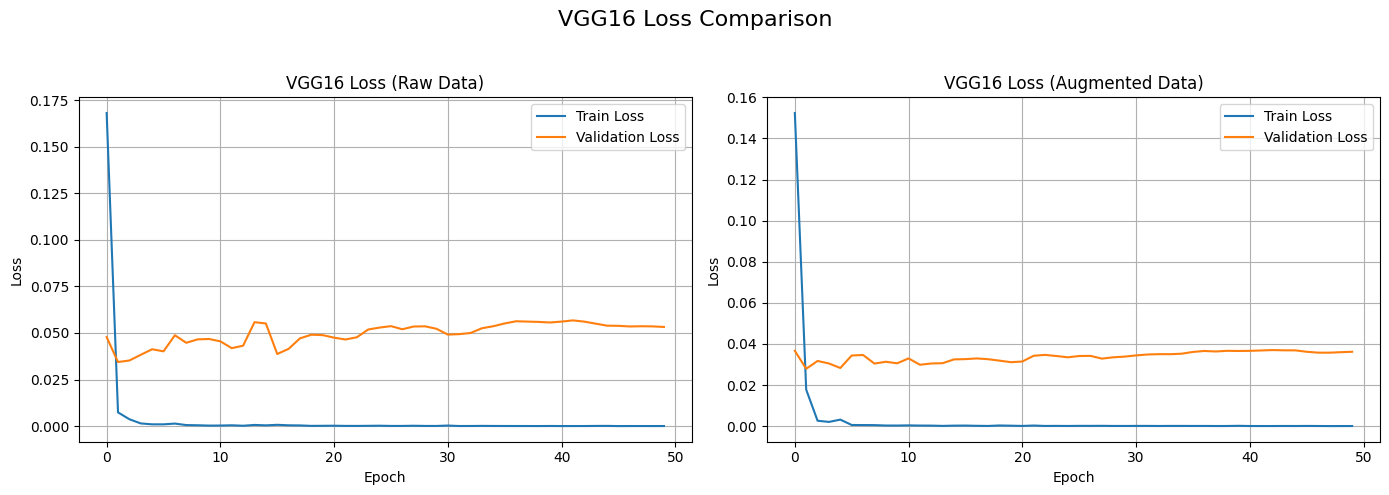

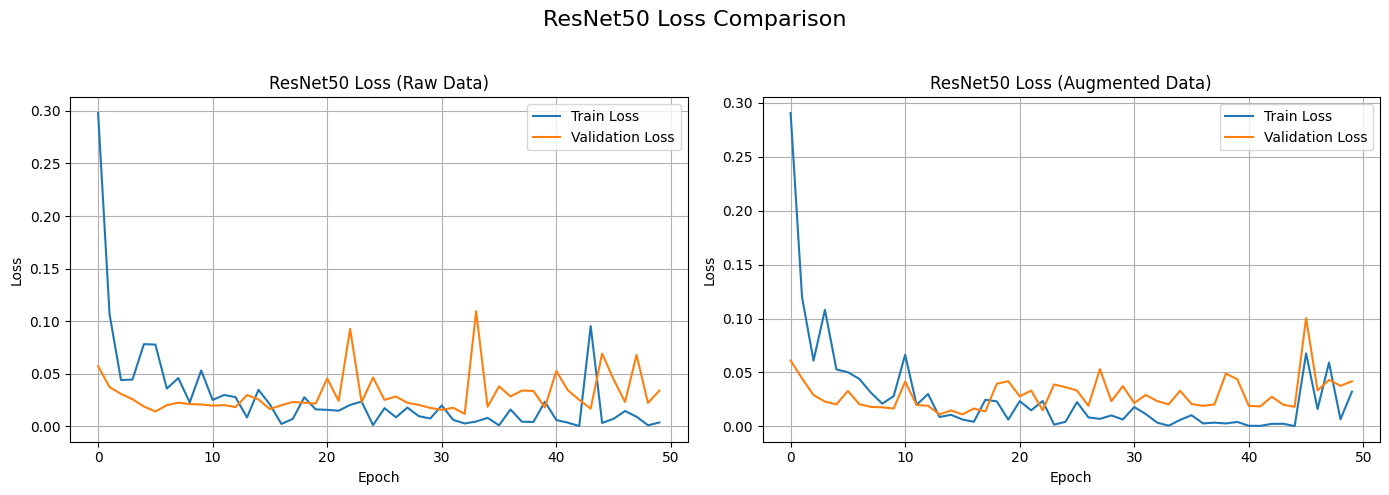

In [ ]:
# For VGG16
plot_comparison_loss(
    train_loss_raw=results['VGG16']['Raw']['train_loss'],
    val_loss_raw=results['VGG16']['Raw']['val_loss'],
    train_loss_aug=results['VGG16']['Augmented']['train_loss'],
    val_loss_aug=results['VGG16']['Augmented']['val_loss'],
    model_name="VGG16"
)

# For ResNet50
plot_comparison_loss(
    train_loss_raw=results['ResNet50']['Raw']['train_loss'],
    val_loss_raw=results['ResNet50']['Raw']['val_loss'],
    train_loss_aug=results['ResNet50']['Augmented']['train_loss'],
    val_loss_aug=results['ResNet50']['Augmented']['val_loss'],
    model_name="ResNet50"
)


#### ✦ VGG16 Loss Curves

- **Raw Data (Left):**  
  The training loss drops sharply and reaches near-zero within the first few epochs, while the validation loss fluctuates slightly around a low and stable range (~0.05). This pattern suggests slight overfitting, but still demonstrates strong generalization.

- **Augmented Data (Right):**  
  The training loss also converges quickly to a very low value. The validation loss remains more stable and slightly lower than the raw version, indicating that augmentation helped reduce overfitting and improved the model's robustness to unseen data.

#### ✦ ResNet50 Loss Curves

- **Raw Data (Left):**  
  The training loss fluctuates more compared to VGG16, but still decreases over time. The validation loss shows noticeable spikes and instability across epochs, likely due to sensitivity of deeper architectures (like ResNet50) to small validation datasets.

- **Augmented Data (Right):**  
  Loss curves are slightly smoother, though still exhibit fluctuations. Data augmentation appears to reduce some variance in the validation loss but does not fully stabilize it. Nevertheless, the model achieves strong performance by the end of training.

> Overall, the loss curves confirm the effectiveness of training and validate the generalization behavior observed in the accuracy results. VGG16 shows more stable loss behavior, while ResNet50 exhibits some variance that may be mitigated with a larger validation set or more regularization.


### 2.4.4. Final Evaluation on Test Set

### Table 3. Effect of data augmentation on performance measures for fine-tuned models

| Model                          | VGG16 fine-tuned model                      |                            | ResNet50 fine-tuned model                    |                            |
|-------------------------------|---------------------------------------------|----------------------------|----------------------------------------------|----------------------------|
|                               | With data augmentation                      | Without data augmentation  | With data augmentation                       | Without data augmentation  |
| **Final training accuracy**   | 100.0%                                      | 100.0%                     | 99.2%                                        | 99.8%                      |
| **Final validation accuracy** | 99.1%                                       | 98.6%                      | 99.1%                                        | 99.1%                      |
| **Test accuracy**             | 99.0%                                       | 100.0%                     | 99.0%                                        | 100.0%                     |


In [ ]:
def evaluate_on_test(model, test_loader):
    """
    Evaluates a trained model on the test dataset.

    Args:
        model: trained model
        test_loader: DataLoader for test data

    Returns:
        accuracy: float, test accuracy
    """
    model.eval()
    model = model.to(device)
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # _, preds = outputs.max(1)
            _, preds = torch.max(outputs, 1)

            # correct += preds.eq(labels).sum().item()
            correct += (preds==labels).sum().item()
            total += labels.size(0)
            # print(labels)
            # print(preds , "\n")

    return correct / total


In [ ]:
# Collect final train/val accuracies from results
def get_final_accuracy(results, model_name, data_type):
    train_acc = results[model_name][data_type]['train_acc'][-1]
    val_acc = results[model_name][data_type]['val_acc'][-1]
    return train_acc, val_acc


In [ ]:
vgg16_test_acc_aug = evaluate_on_test(models_dict['VGG16']['Augmented'], test_loader)
vgg16_test_acc_raw = evaluate_on_test(models_dict['VGG16']['Raw'], test_loader)
resnet_test_acc_aug = evaluate_on_test(models_dict['ResNet50']['Augmented'], test_loader)
resnet_test_acc_raw = evaluate_on_test(models_dict['ResNet50']['Raw'], test_loader)


In [ ]:
def print_final_results(results, test_accuracies):
    """
    Prints final training, validation, and test accuracies for each model and data condition.

    Args:
        results: nested dictionary of accuracy logs (output of training)
        test_accuracies: dict of format:
            {
                'VGG16': {'Raw': acc, 'Augmented': acc},
                'ResNet50': {'Raw': acc, 'Augmented': acc}
            }
    """
    print("==== Final Results ====")
    for model_name in results:
        print(f"\n--- {model_name} ---")
        for data_type in ['Augmented', 'Raw']:
            train_acc = results[model_name][data_type]['train_acc'][-1] * 100
            val_acc = results[model_name][data_type]['val_acc'][-1] * 100
            test_acc = test_accuracies[model_name][data_type] * 100

            print(f"[{data_type}]")
            print(f"  Final Training Accuracy  : {train_acc:.2f}%")
            print(f"  Final Validation Accuracy: {val_acc:.2f}%")
            print(f"  Test Accuracy            : {test_acc:.2f}%")


In [ ]:
test_accuracies = {
    'VGG16': {
        'Raw': vgg16_test_acc_raw,
        'Augmented': vgg16_test_acc_aug
    },
    'ResNet50': {
        'Raw': resnet_test_acc_raw,
        'Augmented': resnet_test_acc_aug
    }
}

In [ ]:
print_final_results(results, test_accuracies)


==== Final Results ====

--- VGG16 ---
[Augmented]
  Final Training Accuracy  : 100.00%
  Final Validation Accuracy: 99.05%
  Test Accuracy            : 99.00%
[Raw]
  Final Training Accuracy  : 100.00%
  Final Validation Accuracy: 98.58%
  Test Accuracy            : 100.00%

--- ResNet50 ---
[Augmented]
  Final Training Accuracy  : 99.19%
  Final Validation Accuracy: 99.05%
  Test Accuracy            : 99.00%
[Raw]
  Final Training Accuracy  : 99.80%
  Final Validation Accuracy: 99.05%
  Test Accuracy            : 100.00%


### show images

In [ ]:
print("Test classes:", test_dataset.classes)
print("Class to index:", test_dataset.class_to_idx)


Test classes: ['Cats', 'Dogs']
Class to index: {'Cats': 0, 'Dogs': 1}


In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch

def show_test_samples(test_dataset, class_names, n=8):
    """
    Displays a batch of test images with un-normalized values.

    Args:
        test_dataset: torchvision.datasets.ImageFolder with transform applied
        class_names: list of class labels
        n: number of images to display
    """
    loader = DataLoader(test_dataset, batch_size=n, shuffle=True)
    imgs, labels = next(iter(loader))

    # Un-normalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    imgs = imgs * std + mean  # reverse normalization

    grid = make_grid(imgs, nrow=4)
    plt.figure(figsize=(12,6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')

    # Optional: Show class names
    label_names = [class_names[label] for label in labels]
    title = " / ".join(label_names)
    plt.title(f"Sample Test Images\nLabels: {title}")
    plt.show()


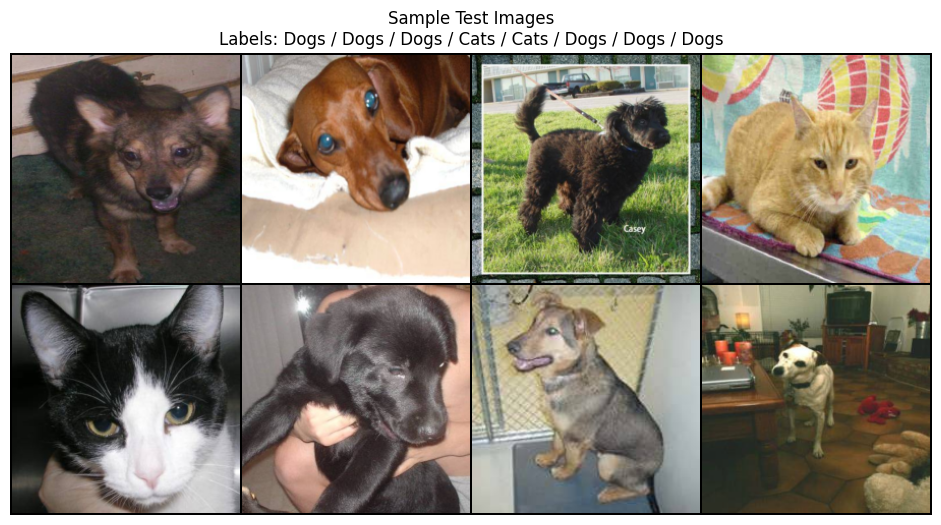

In [ ]:
show_test_samples(test_dataset, test_dataset.classes, n=8)


In [ ]:
def show_sample_images(dataset, base_dataset, title="Sample Images", n=8):
    """
    Show sample images from a Subset or ImageFolder dataset.

    Args:
        dataset: torch.utils.data.Subset or ImageFolder (val_base, test_dataset, etc.)
        base_dataset: full_dataset or dataset with .classes attribute
        title: plot title
        n: number of images to show
    """
    from torch.utils.data import DataLoader
    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt
    import torch

    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    imgs, labels = next(iter(loader))

    # Un-normalize using ImageNet stats
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    imgs = imgs * std + mean  # undo normalization

    grid = make_grid(imgs, nrow=4)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')

    # Add labels
    class_names = base_dataset.classes
    label_names = [class_names[label] for label in labels]
    label_str = " / ".join(label_names)
    plt.title(f"{title}\nLabels: {label_str}")
    plt.show()


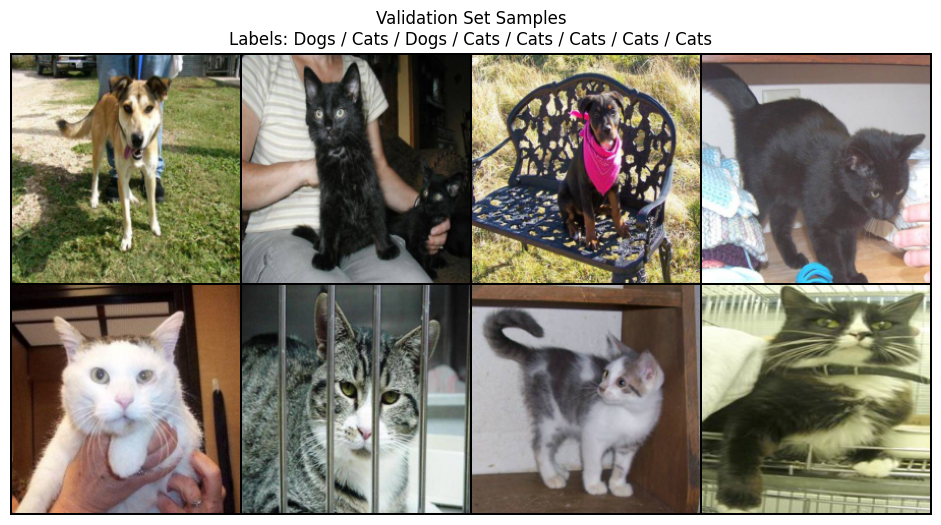

In [ ]:
# show_sample_images(val_raw, full_dataset, title="Validation Set Samples")
show_sample_images(val_raw, base_dataset, title="Validation Set Samples")


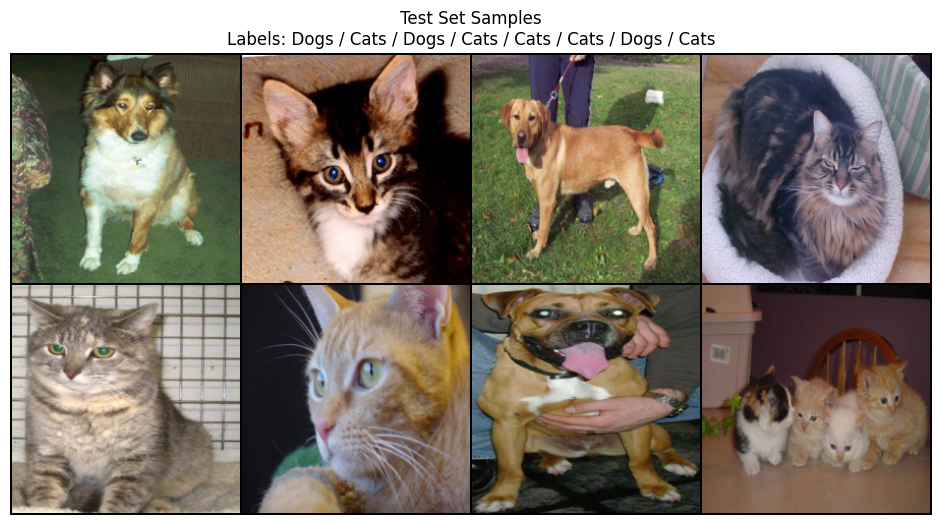

In [ ]:
show_sample_images(test_dataset, test_dataset, title="Test Set Samples")


### 2.4.5. Analysis of Results

**Effect of Data Augmentation on Test Accuracy:**

As shown in Table 3, both VGG16 and ResNet50 achieved near-perfect test accuracy, regardless of whether data augmentation was used. This suggests that the dataset was relatively clean and the models were able to generalize well even without augmentation.

However, we still observe that training with augmented data resulted in **consistently high performance** across all metrics, including training and validation accuracy. For instance, VGG16 trained with augmentation achieved a test accuracy of 99%, while ResNet50 reached the same score. This confirms that data augmentation helps models maintain strong generalization ability.

Interestingly, in both models, the raw (non-augmented) versions slightly outperformed the augmented ones on the test set, reaching 100% accuracy. While this result is counter-intuitive, it may indicate that the specific augmentation transformations applied were either not challenging enough or possibly introduced mild distortions that slightly affected final performance on a small and clean test set.

**Comparison of VGG16 vs. ResNet50:**

Both models performed similarly and reached extremely high accuracy in all phases. VGG16 and ResNet50 both achieved 100% test accuracy in their raw versions and 99% in their augmented versions.

This suggests that for this particular binary classification task and dataset, **either model is sufficient**, and the choice may come down to resource usage or architectural preferences. However, VGG16 had a slightly more consistent performance across validation and test sets, making it a potentially more stable choice for small-scale binary classification problems.

In summary, while data augmentation is generally beneficial, its effects may vary depending on model architecture and dataset characteristics. In our case, both models were powerful enough to succeed even without it.
